In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import ruptures as rpt
from sklearn.preprocessing import StandardScaler
import ta
import vectorbt as vbt
import matplotlib.pyplot as plt

# Load BTC data from Yahoo Finance over a longer period (2022 - 2025)
data = yf.download("BTC-USD", start="2022-01-01", end="2025-01-01")["Close"]


def prepare_data(df):
    df = pd.DataFrame(df, columns=["Close"])
    df["returns"] = np.log(df["Close"] / df["Close"].shift(1))
    df["ma50"] = df["Close"].rolling(window=50).mean()
    df["rsi"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()
    df["zscore"] = StandardScaler().fit_transform(df["Close"].values.reshape(-1, 1))
    df["bollinger_high"] = (
        df["Close"].rolling(20).mean() + 2 * df["Close"].rolling(20).std()
    )
    df["bollinger_low"] = (
        df["Close"].rolling(20).mean() - 2 * df["Close"].rolling(20).std()
    )

    # Gaussian Process Change Point Detection
    returns_without_na = df["returns"].dropna().values
    algo = rpt.Pelt(model="rbf").fit(returns_without_na)
    change_points = algo.predict(pen=10)
    df["regime"] = "unknown"

    # Assign regimes based on change points
    if change_points:
        first_cp = change_points[0]
        df.iloc[:first_cp, df.columns.get_loc("regime")] = (
            "trend" if df["returns"].iloc[:first_cp].mean() > 0 else "reversion"
        )
    for i in range(1, len(change_points)):
        start, end = change_points[i - 1], change_points[i]
        regime_type = (
            "trend" if df["returns"].iloc[start:end].mean() > 0 else "reversion"
        )
        df.iloc[start:end, df.columns.get_loc("regime")] = regime_type

    # Generate signals
    df["signal"] = 0
    for i in range(1, len(df)):
        if df.loc[df.index[i], "regime"] == "trend":
            # Slow momentum strategy
            if (
                df.loc[df.index[i], "Close"] > df.loc[df.index[i], "ma50"]
                and df.loc[df.index[i], "rsi"] > 50
            ):
                df.loc[df.index[i], "signal"] = 1  # Long
            elif (
                df.loc[df.index[i], "Close"] < df.loc[df.index[i], "ma50"]
                and df.loc[df.index[i], "rsi"] < 50
            ):
                df.loc[df.index[i], "signal"] = -1  # Short
        elif df.loc[df.index[i], "regime"] == "reversion":
            # Fast mean reversion strategy
            if (
                df.loc[df.index[i], "Close"] < df.loc[df.index[i], "bollinger_low"]
                or df.loc[df.index[i], "zscore"] < -2
            ):
                df.loc[df.index[i], "signal"] = 1  # Long
            elif (
                df.loc[df.index[i], "Close"] > df.loc[df.index[i], "bollinger_high"]
                or df.loc[df.index[i], "zscore"] > 2
            ):
                df.loc[df.index[i], "signal"] = -1  # Short

    return df


# Prepare data for the extended testing period
btc = prepare_data(data)

# Generate entries and exits for the portfolio
entries = btc["signal"] == 1
exits = btc["signal"] == -1

# Create and evaluate the portfolio
btc_pf = vbt.Portfolio.from_signals(
    close=btc["Close"], entries=entries, exits=exits, init_cash=100_000
)
btc_pf.plot(title="BTC Portfolio Performance (2022 - 2025)")
plt.show()

# Print summary stats
btc_stats = btc_pf.stats()
print("BTC Performance Metrics (2022 - 2025)")
print(btc_stats)

[*********************100%%**********************]  1 of 1 completed


BTC Performance Metrics (2022 - 2025)
Start                                2022-01-01 00:00:00
End                                  2024-12-31 00:00:00
Period                                1096 days 00:00:00
Start Value                                     100000.0
End Value                                  240649.121411
Total Return [%]                              140.649121
Benchmark Return [%]                           95.922517
Max Gross Exposure [%]                             100.0
Total Fees Paid                                      0.0
Max Drawdown [%]                               46.813818
Max Drawdown Duration                  601 days 00:00:00
Total Trades                                          22
Total Closed Trades                                   22
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   31.818182
Best Trade [%]                                 54.

Optimized Weights (CVaR):
Asset_0: 16.72%
Asset_1: 16.16%
Asset_2: 24.50%
Asset_3: 18.28%
Asset_4: 24.34%
Expected annual return: 48.9%
Conditional Value at Risk: 1.74%

Discrete Allocation: {'Asset_0': 139, 'Asset_1': 134, 'Asset_2': 146, 'Asset_3': 105, 'Asset_4': 85}
Funds Remaining: $51.23


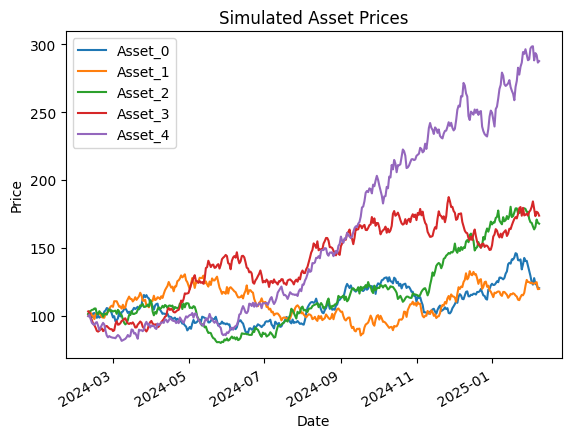

In [2]:
# Install PyPortfolioOpt if you haven't already:
# pip install PyPortfolioOpt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pypfopt import expected_returns, risk_models
from pypfopt.efficient_frontier import EfficientCVaR
from pypfopt import discrete_allocation

# 1. Generate some mock daily price data
#    In practice, you'd replace this with real price data (e.g., from yfinance).
np.random.seed(42)
dates = pd.date_range(datetime.today() - timedelta(days=365), periods=365)
n_assets = 5

# Use random log-returns to simulate price evolution
log_returns = np.random.normal(loc=0.0005, scale=0.02, size=(365, n_assets))
prices = 100 * np.exp(np.cumsum(log_returns, axis=0))
mock_prices = pd.DataFrame(
    prices, index=dates, columns=[f"Asset_{i}" for i in range(n_assets)]
)

# 2. Calculate expected returns and the covariance matrix
mu = expected_returns.mean_historical_return(mock_prices, frequency=252)
# Note: frequency=252 is typical for 'trading days in a year'
S = risk_models.sample_cov(mock_prices, frequency=252)

# 3. Use the EfficientCVaR class to minimize downside risk
#    while trying to maintain decent returns.
ef_cvar = EfficientCVaR(mu, mock_prices.pct_change().dropna())
ef_cvar.min_cvar()  # Minimize Conditional Value at Risk
weights_cvar = ef_cvar.clean_weights()

print("Optimized Weights (CVaR):")
for asset, weight in weights_cvar.items():
    print(f"{asset}: {weight:.2%}")

# 4. Evaluate performance
ef_cvar.portfolio_performance(verbose=True)

# (Optional) Convert continuous weights to a discrete allocation
latest_prices = mock_prices.iloc[-1]
da = discrete_allocation.DiscreteAllocation(
    weights_cvar,
    latest_prices,
    total_portfolio_value=100000,  # Example investment amount
)
allocation, leftover = da.lp_portfolio()
print("\nDiscrete Allocation:", allocation)
print("Funds Remaining: ${:.2f}".format(leftover))

# Plot the mock price history for a quick visual check
mock_prices.plot(title="Simulated Asset Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import ruptures as rpt
from sklearn.preprocessing import StandardScaler
import ta
import vectorbt as vbt
import matplotlib.pyplot as plt


def prepare_data(df, penalty=10, ma_window=50, rsi_thresh=50):
    """
    Prepare the data for the BTC strategy.

    :param df: DataFrame with 'Close' price.
    :param penalty: Penalty parameter for PELT changepoint detection.
    :param ma_window: Window size for moving average.
    :param rsi_thresh: RSI threshold for switching signals.
    :return: DataFrame with calculated signals.
    """
    df = pd.DataFrame(df, columns=["Close"])
    df["returns"] = np.log(df["Close"] / df["Close"].shift(1))
    df["ma50"] = df["Close"].rolling(window=ma_window).mean()
    df["rsi"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()
    df["zscore"] = StandardScaler().fit_transform(df["Close"].values.reshape(-1, 1))
    df["bollinger_high"] = (
        df["Close"].rolling(20).mean() + 2 * df["Close"].rolling(20).std()
    )
    df["bollinger_low"] = (
        df["Close"].rolling(20).mean() - 2 * df["Close"].rolling(20).std()
    )

    # Gaussian Process Change Point Detection (PELT)
    returns_without_na = df["returns"].dropna().values
    algo = rpt.Pelt(model="rbf").fit(returns_without_na)
    change_points = algo.predict(pen=penalty)
    df["regime"] = "unknown"

    # Assign regimes based on change points
    if change_points:
        first_cp = change_points[0]
        df.iloc[:first_cp, df.columns.get_loc("regime")] = (
            "trend" if df["returns"].iloc[:first_cp].mean() > 0 else "reversion"
        )
    for i in range(1, len(change_points)):
        start, end = change_points[i - 1], change_points[i]
        regime_type = (
            "trend" if df["returns"].iloc[start:end].mean() > 0 else "reversion"
        )
        df.iloc[start:end, df.columns.get_loc("regime")] = regime_type

    # Generate signals
    df["signal"] = 0
    for i in range(1, len(df)):
        if df.loc[df.index[i], "regime"] == "trend":
            # Slow momentum strategy
            if (
                df.loc[df.index[i], "Close"] > df.loc[df.index[i], "ma50"]
                and df.loc[df.index[i], "rsi"] > rsi_thresh
            ):
                df.loc[df.index[i], "signal"] = 1  # Long
            elif (
                df.loc[df.index[i], "Close"] < df.loc[df.index[i], "ma50"]
                and df.loc[df.index[i], "rsi"] < rsi_thresh
            ):
                df.loc[df.index[i], "signal"] = -1  # Short
        elif df.loc[df.index[i], "regime"] == "reversion":
            # Fast mean reversion strategy
            if (
                df.loc[df.index[i], "Close"] < df.loc[df.index[i], "bollinger_low"]
                or df.loc[df.index[i], "zscore"] < -2
            ):
                df.loc[df.index[i], "signal"] = 1  # Long
            elif (
                df.loc[df.index[i], "Close"] > df.loc[df.index[i], "bollinger_high"]
                or df.loc[df.index[i], "zscore"] > 2
            ):
                df.loc[df.index[i], "signal"] = -1  # Short

    return df


def combined_signal(df, alpha=0.5):
    """
    Combine slow momentum and fast mean-reversion z-scores
    into a single signal, weighted by alpha.
    alpha=1.0 -> stronger weighting to slow momentum strategy
    alpha=0.0 -> stronger weighting to fast mean-reversion strategy
    """
    # For demonstration, treat 'signal' as slow-momentum.
    # We'll create a separate 'fast_signal' for demonstration.
    fast_signal = np.where(
        (df["Close"] < df["bollinger_low"]) | (df["zscore"] < -2),
        1,
        np.where((df["Close"] > df["bollinger_high"]) | (df["zscore"] > 2), -1, 0),
    )
    # Weighted final signal
    df["final_signal"] = alpha * df["signal"] + (1 - alpha) * fast_signal
    # Convert to discrete sign (long, neutral, short)
    df["final_signal"] = np.where(
        df["final_signal"] > 0, 1, np.where(df["final_signal"] < 0, -1, 0)
    )
    return df


# Load BTC data from Yahoo Finance (example period)
data = yf.download("BTC-USD", start="2023-01-01", end="2024-01-01")["Close"]

# Possible ranges for tuning (small example)
penalties = [5, 10, 15]
alphas = [0.2, 0.5, 0.8]
ma_windows = [30, 50]  # rolling MA window
rsi_thresholds = [45, 50, 55]

best_sharpe = -999
best_params = (None, None, None, None)
results = []

for pen in penalties:
    for alpha in alphas:
        for ma_win in ma_windows:
            for rsi_thresh in rsi_thresholds:
                # Prepare data
                df_prepared = prepare_data(
                    data, penalty=pen, ma_window=ma_win, rsi_thresh=rsi_thresh
                )
                # Combine signals
                df_prepared = combined_signal(df_prepared, alpha=alpha)

                # Build portfolio in vectorbt
                entries = df_prepared["final_signal"] == 1
                exits = df_prepared["final_signal"] == -1

                btc_pf = vbt.Portfolio.from_signals(
                    close=df_prepared["Close"],
                    entries=entries,
                    exits=exits,
                    init_cash=100_000,
                )

                stats = btc_pf.stats()
                sharpe_ratio = stats.get("Sharpe Ratio", np.nan)

                results.append(
                    {
                        "penalty": pen,
                        "alpha": alpha,
                        "ma_window": ma_win,
                        "rsi_thresh": rsi_thresh,
                        "sharpe": sharpe_ratio,
                    }
                )

                if sharpe_ratio is not None and sharpe_ratio > best_sharpe:
                    best_sharpe = sharpe_ratio
                    best_params = (pen, alpha, ma_win, rsi_thresh)

print("Best Sharpe Ratio:", best_sharpe)
print("Best Params (penalty, alpha, ma_window, rsi_thresh):", best_params)

# If you want to visualize the best combination:
pen_opt, alpha_opt, ma_win_opt, rsi_opt = best_params
df_final = prepare_data(data, penalty=pen_opt, ma_window=ma_win_opt, rsi_thresh=rsi_opt)
df_final = combined_signal(df_final, alpha=alpha_opt)
entries_opt = df_final["final_signal"] == 1
exits_opt = df_final["final_signal"] == -1

btc_pf_opt = vbt.Portfolio.from_signals(
    close=df_final["Close"], entries=entries_opt, exits=exits_opt, init_cash=1_000_000
)
btc_pf_opt.plot(title="BTC Portfolio with Tuned Parameters")
plt.show()
btc_stats_opt = btc_pf_opt.stats()
print("Tuned BTC Performance Metrics:")
print(btc_stats_opt)

[*********************100%%**********************]  1 of 1 completed


Best Sharpe Ratio: 2.578713849403667
Best Params (penalty, alpha, ma_window, rsi_thresh): (5, 0.8, 50, 45)
Tuned BTC Performance Metrics:
Start                         2023-01-01 00:00:00
End                           2023-12-31 00:00:00
Period                          365 days 00:00:00
Start Value                             1000000.0
End Value                          2427588.754287
Total Return [%]                       142.758875
Benchmark Return [%]                   154.225467
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                         11.97048
Max Drawdown Duration            99 days 00:00:00
Total Trades                                    5
Total Closed Trades                             5
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 80.0
Best Trade [%]                          55.323235
Worst Trade 

In [4]:
btc_pf.trades.plot(title="Trade Summary")
plt.show()

# 2. (Optional) If you’d like to see a human-readable summary of all trades:
trades_df = btc_pf.trades.records_readable
print(trades_df.head())  # or print the entire DataFrame

# 3. (Optional) For more details, you can also print or inspect the portfolio’s stats:
print("Portfolio Stats:")
btc_pf.stats()

   Exit Trade Id  Column      Size Entry Timestamp  Avg Entry Price  \
0              0       0  6.015009      2023-01-01     16625.080078   
1              1       0  5.558902      2023-03-13     24197.533203   
2              2       0  5.287338      2023-05-05     29534.384766   
3              3       0  5.311134      2023-06-20     28327.488281   
4              4       0  5.714028      2023-09-19     27211.117187   

   Entry Fees Exit Timestamp  Avg Exit Price  Exit Fees           PnL  \
0         0.0     2023-03-03    22362.679688        0.0  34511.711116   
1         0.0     2023-05-01    28091.568359        0.0  21646.559078   
2         0.0     2023-05-07    28454.978516        0.0  -5707.185512   
3         0.0     2023-07-30    29275.308594        0.0   5034.000639   
4         0.0     2023-09-21    26567.632812        0.0  -3676.887732   

     Return Direction  Status  Position Id  
0  0.345117      Long  Closed            0  
1  0.160927      Long  Closed            1  

Start                         2023-01-01 00:00:00
End                           2023-12-31 00:00:00
Period                          365 days 00:00:00
Start Value                              100000.0
End Value                           227477.003332
Total Return [%]                       127.477003
Benchmark Return [%]                   154.225467
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        11.297879
Max Drawdown Duration           191 days 00:00:00
Total Trades                                    8
Total Closed Trades                             8
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 50.0
Best Trade [%]                          53.080296
Worst Trade [%]                         -3.654744
Avg Winning Trade [%]                    26.75766
Avg Losing Trade [%]                    -2.034382


In [5]:
fig = btc_pf.plot()
fig.update_layout(title=f'SMFR', xaxis_title='Date', yaxis_title='Portfolio Value')
fig.show()